In [8]:
import sys
sys.path.append('core')
import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
from utils import flow_viz
from utils.utils import InputPadder

import imageio.v3 as imageio

In [2]:
DEVICE = 'cuda'

In [3]:
class Args():
    def __init__(self, small=False,mixed_precision=False,alternate_corr=False):
        self.small=small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr
        self.params = ['small', 'mixed_precision','alternate_corr']
    def __contains__(self, item):
        return item in self.params

args = Args(small=True)
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load('/media/shirbar/DATA/codes/RAFT/models/raft-small.pth'))

model = model.module
model.to(DEVICE)
model.eval()

RAFT(
  (fnet): SmallEncoder(
    (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BottleneckBlock(
        (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BottleneckBlock(
        (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stri

In [36]:
vid=imageio.imread('/media/shirbar/DATA/codes/pips/feeding.avi',plugin='pyav')
vid = vid.astype(np.uint8)
#vid.shape

In [7]:
vid[:-1,...].shape

(40, 400, 400, 3)

In [63]:
def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)
    return img_flo

In [66]:
load_image = lambda img: torch.from_numpy(img).permute(2, 0, 1).float()[None].to(DEVICE)
flo_images = []
with torch.no_grad():
    for im1, im2 in zip(vid[0:40:5,...], vid[1:41:5,...]):
        image1 = load_image(im1)
        image2 = load_image(im2)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        flo_images.append(viz(image1, flow_up))


In [67]:
image1.shape,image2.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 3, 400, 400]))

In [68]:
flo_images = [Image.fromarray(img.astype(np.uint8)) for img in flo_images]
out_fn = './raft_test_8frames.gif'
flo_images[0].save(out_fn, save_all=True, append_images=flo_images[1:])

In [62]:
for i in range(len(flo_images)):
    print(flo_images[i].dtype,flo_images[i].shape)

float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)
float32 (800, 400, 3)


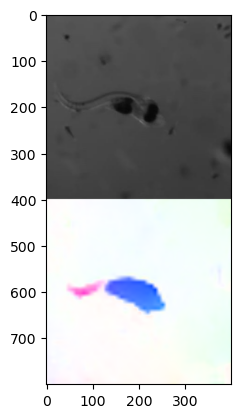

In [48]:
import matplotlib.pyplot as plt

plt.imshow(flo_images[10])

In [25]:
flo_images[12].min()

0.0